<a href="https://colab.research.google.com/github/margaretmz/CartoonGAN-e2e-tflite-tutorial/blob/master/ml/CartoonGAN%2BESRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 324.1MB 51kB/s 
     |████████████████████████████████| 460kB 51.1MB/s 
     |████████████████████████████████| 6.8MB 49.8MB/s 


In [2]:
!git clone --branch inference-tf-2.x https://github.com/steubk/White-box-Cartoonization.git
!pip install --upgrade tf_slim

Cloning into 'White-box-Cartoonization'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 188 (delta 2), reused 7 (delta 1), pack-reused 175
Receiving objects: 100% (188/188), 63.41 MiB | 37.12 MiB/s, done.
Resolving deltas: 100% (61/61), done.
     |████████████████████████████████| 358kB 2.8MB/s 


In [3]:
import sys
sys.path.append('./White-box-Cartoonization/test_code')

import cartoonize
import network
import guided_filter

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [4]:
!mkdir saved_model_dir
model_path = './White-box-Cartoonization/test_code/saved_models'

In [9]:
tf.reset_default_graph()
  
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
  # Create placeholder for the input
  input_photo = tf.placeholder(tf.float32, [1, None, None, 3], name='input_photo')
  
  # Run the input placeholder through the generator, and then apply a 
  # filter to process the generator output
  network_out = network.unet_generator(input_photo)
  final_out = guided_filter.guided_filter(input_photo, network_out, r=1, eps=5e-3)
  final_out = tf.identity(final_out, name='final_output') # Create an identical filtering layer 
 
  # The above process is basically needed to construct the computation graph for the
  # current session
  
  # Get the generator variables and restore the pre-trained checkpoints in the 
  # current session
  all_vars = tf.trainable_variables()
  gene_vars = [var for var in all_vars if 'generator' in var.name]
  saver = tf.train.Saver(var_list=gene_vars)
  sess.run(tf.global_variables_initializer())
  saver.restore(sess, tf.train.latest_checkpoint(model_path))
  
  # Export to SavedModel
  tf.saved_model.simple_save(
      sess,
      '/content/saved_model_dir',
      inputs={input_photo.name: input_photo},
      outputs={final_out.name: final_out})

INFO:tensorflow:Restoring parameters from ./White-box-Cartoonization/test_code/saved_models/model-33999
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/saved_model_dir/saved_model.pb


In [10]:
!ls -lh saved_model_dir
!ls -lh saved_model_dir/variables

total 144K
-rw-r--r-- 1 root root 137K Aug  5 10:17 saved_model.pb
drwxr-xr-x 2 root root 4.0K Aug  5 10:17 variables
total 5.7M
-rw-r--r-- 1 root root 5.6M Aug  5 10:17 variables.data-00000-of-00001
-rw-r--r-- 1 root root 1.6K Aug  5 10:17 variables.index


**A runtime restart is required here.**

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.executing_eagerly())

2.4.0-dev20200805
True


In [12]:
import cv2
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model = tf.saved_model.load('saved_model_dir')
concrete_func = model.signatures[
    tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 256, 256, 3]) # Just comment this line if you want to export a model with dynamic shape support
    
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

open('whitebox_cartoon_gan_dr.tflite', 'wb').write(tflite_model)

Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
to_proto not supported in EAGER mode.


1782544

In [4]:
!ls -lh whitebox_cartoon_gan_dr.tflite

-rw-r--r-- 1 root root 1.7M Aug  5 10:21 whitebox_cartoon_gan_dr.tflite


In [6]:
# Sample image to infer
wget -O image.jpg https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg

--2020-08-05 10:22:52--  https://raw.githubusercontent.com/sayakpaul/portfolio/master/images/image_sayak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111191 (109K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>] 108.58K  --.-KB/s    in 0.04s   

2020-08-05 10:22:52 (2.83 MB/s) - ‘image.jpg’ saved [111191/111191]



In [7]:
# Reference: https://www.tensorflow.org/lite/models/style_transfer/overview
def load_img(path_to_img):
  img = cv2.imread(path_to_img)
  img = img.astype(np.float32) / 127.5 - 1
  img = np.expand_dims(img, 0)
  img = tf.convert_to_tensor(img)
  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim=224):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

In [8]:
source_image = load_img('/content/image.jpg')
preprocessed_source_image = preprocess_image(source_image, target_dim=256)
preprocessed_source_image.shape 

TensorShape([1, 256, 256, 3])

In [9]:
interpreter = tf.lite.Interpreter(model_path='/content/whitebox_cartoon_gan_dr.tflite')
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], preprocessed_source_image)
interpreter.invoke()

raw_prediction = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

In [10]:
output = (np.squeeze(raw_prediction)+1.0)*127.5
output = np.clip(output, 0, 255).astype(np.uint8)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

In [14]:
hr = PIL.Image.fromarray(output)
hr.save('cartoonized_image.jpg')

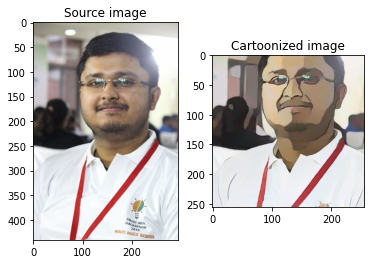

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(plt.imread('/content/image.jpg'))
plt.title('Source image')
plt.subplot(1, 2, 2)
plt.imshow(output)
plt.title('Cartoonized image')
plt.show()

In [ ]:
# ESRGAN model
!wget https://github.com/margaretmz/esrgan-e2e-tflite-tutorial/raw/master/ml/add%20metadata/model_with_metadata/esrgan_dr.tflite

In [15]:
# Utility for image loading and preprocessing
def load_img(path_to_img, scale_factor=4, save_path="downsampled_image.jpg"):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = img.numpy()
    hr = img = PIL.Image.fromarray(img)
    if not scale_factor:
      width, height = 512, 512
      scale_factor = 4
    else:
      width, height = img.size
    if save_path:
      lr = img = img.resize(
          (width // scale_factor, height // scale_factor),
          PIL.Image.BICUBIC)
      lr.save(save_path)
    img = np.asarray(img)
    img = tf.cast(img, dtype=tf.float32)
    img = img[tf.newaxis, :]
    return img

In [16]:
low_res_image = load_img('/content/cartoonized_image.jpg', None)
low_res_image.shape.as_list()

[1, 128, 128, 3]

In [17]:
# Load the image.
low_res_image = load_img('downsampled_image.jpg', None, None)

# Load the model.
interpreter = tf.lite.Interpreter(model_path=f'/content/esrgan_dr.tflite')

# Set model input.
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# Invoke the interpreter to run inference.
interpreter.set_tensor(input_details[0]['index'], low_res_image)
interpreter.invoke()

# Retrieve the enhanced image.
enhanced_img = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()

In [18]:
def get_concat_h(im1, im2):
    dst = PIL.Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

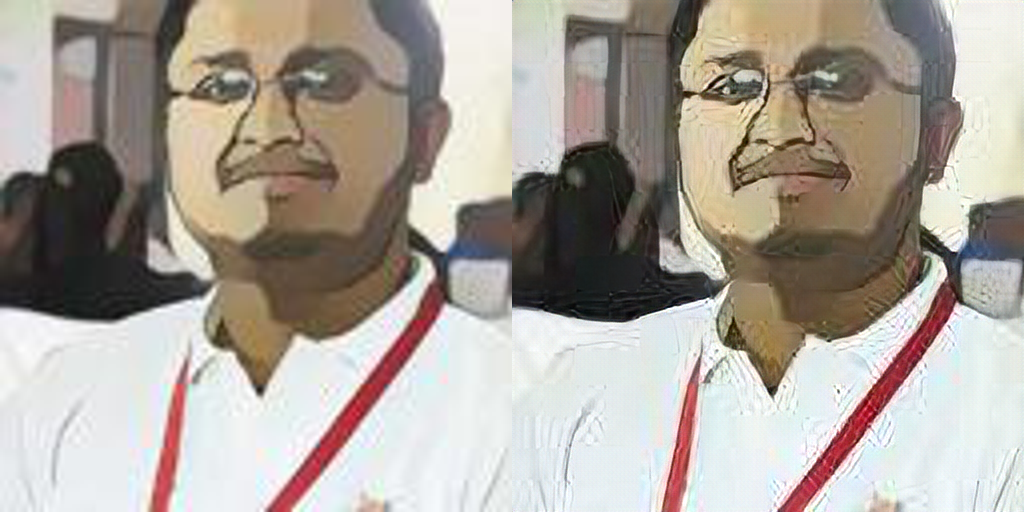

In [19]:
a = tf.cast(tf.clip_by_value(enhanced_img[0], 0, 255), tf.uint8)
super_resolution_img = PIL.Image.fromarray(a.numpy(), 'RGB')
super_resolution_img = super_resolution_img.resize((512, 512))

down_sampled_image = PIL.Image.open('/content/downsampled_image.jpg').resize((512, 512))

get_concat_h(down_sampled_image, super_resolution_img)